맹주리, 우정연

### Background
* Many online shopping mall websites present their products in an infinite scroll of images
* It is hard for consumers to efficiently look for products in need

### Objective
* Implement deep learning techniques tackle such problems
* Develop a method that automatically classifies fashion items and provide matching and similar items

### Dataset
* Kaggle fashion product image dataset from https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

### Methods
* Classification: train a model to classify a product image into a multilabel category (ex. shorts/summer)
* Matching: make pair combinations of the fashion items
* Recommendation: recommend a similar-looking item of the classified product using REsNet 50

### Conclusion
* Experimented with models including CNN, DNN, and ResNet
* Has potential for multilable image classification
* For future development, consider more product features (patterns, gender, etc.) and matching combinations (including accessories, usage, etc.)

## Classification

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [115]:
DATASET_PATH = "C:/Users/maeng/Desktop/archive/myntradataset/"
print(os.listdir(DATASET_PATH))

df = pd.read_csv(DATASET_PATH + 'styles.csv')

df['image_path'] = df['id'].astype(str) +'.jpg'
df=df.drop(columns=['gender', 'masterCategory', 'year', 'productDisplayName', 'subCategory'])

array=['Shirts', 'Jeans', 'Tshirts', 'Waistcoat', 'Shorts', 'Blazers', 'Trousers', 'Booties']
df = df.loc[df['articleType'].isin(array)]

df=df.dropna(axis=0)
df

['images', 'styles.csv', 'styles2.csv']


,id,articleType,baseColour,season,usage,image_path
0,15970,Shirts,Navy Blue,Fall,Casual,15970.jpg
1,39386,Jeans,Blue,Summer,Casual,39386.jpg
4,53759,Tshirts,Grey,Summer,Casual,53759.jpg
5,1855,Tshirts,Grey,Summer,Casual,1855.jpg
6,30805,Shirts,Green,Summer,Ethnic,30805.jpg
...,...,...,...,...,...,...
44434,1644,Tshirts,Red,Fall,Sports,1644.jpg
44436,30614,Tshirts,Black,Summer,Sports,30614.jpg
44437,13496,Tshirts,Blue,Fall,Casual,13496.jpg
44439,12544,Tshirts,Peach,Fall,Casual,12544.jpg


In [116]:
df['season'] = df['season'].replace({"Spring": "1", "Summer": "2", "Fall": "3", "Winter":"4"})

df['articleType'] = df['articleType'].replace({'Shirts':'1', 'Jeans':'2', 'Tshirts':'3', 'Waistcoat':'4',
                                               'Shorts':'5', 'Blazers':'6', 'Trousers':'7', 'Booties':'8'})

In [117]:
df['new_class']=df['articleType']+df['season']

df

,id,articleType,baseColour,season,usage,image_path,new_class
0,15970,1,Navy Blue,3,Casual,15970.jpg,13
1,39386,2,Blue,2,Casual,39386.jpg,22
4,53759,3,Grey,2,Casual,53759.jpg,32
5,1855,3,Grey,2,Casual,1855.jpg,32
6,30805,1,Green,2,Ethnic,30805.jpg,12
...,...,...,...,...,...,...,...
44434,1644,3,Red,3,Sports,1644.jpg,33
44436,30614,3,Black,2,Sports,30614.jpg,32
44437,13496,3,Blue,3,Casual,13496.jpg,33
44439,12544,3,Peach,3,Casual,12544.jpg,33


* data augmentation not used since it leads to lower accuracy??
* batch size 64 --> 32
* validation split 0.2 --> 0.3 (becasue small dataset)
* early stopping used
* dropout removed from input layer
* size increase? 32 --> 64 (because few epochs needed)

VGGNET: input size 너무 큼 (224) -> 최대한 CNN으로 구현...


In [23]:
batch_size=32

from keras_preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(validation_split=0.3,
                                     rescale = 1./255,
                                     horizontal_flip = True
                                    )

training_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=DATASET_PATH + "images",
    x_col="image_path",
    y_col="new_class",
    target_size=(64,64),
    batch_size=batch_size,
    subset="training"
)

validation_generator = image_generator.flow_from_dataframe(
    dataframe=df,
    directory=DATASET_PATH + "images",
    x_col="image_path",
    y_col="new_class",
    target_size=(64,64),
    batch_size=batch_size,
    subset="validation"
)

classes = len(training_generator.class_indices)


test_datagen=ImageDataGenerator()

test_generator=test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=DATASET_PATH + "images",
    x_col="image_path",
    y_col=None,
    target_size=(64,64),
    batch_size=batch_size,
    class_mode=None
)

#generating train, validation, test sets

Found 8396 validated image filenames belonging to 24 classes.
Found 3598 validated image filenames belonging to 24 classes.
Found 11994 validated image filenames.


In [282]:
model = Sequential() # initializing network
model.add(Conv2D(32, (3, 3), padding='same', activation="relu",
                 input_shape=(64,64,3))) # first conv layer, 3x3 filter matrix, channel width=3
model.add(MaxPooling2D(pool_size=(2, 2))) # pooling layer


model.add(Conv2D(32, (3, 3), padding='same', activation="relu")) #second conv
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten()) #connecting layer between convolution and dense layers
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(24, activation='softmax')) # output layer

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [278]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(1))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
#model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="binary_crossentropy",metrics=["accuracy"])

In [279]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_48 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_49 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 30752)           

In [227]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [283]:
STEP_SIZE_TRAIN=training_generator.n//training_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = model.fit_generator(generator=training_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50, callbacks=[es])

Epoch 1/50
262/262 [==============================] - 21s 80ms/step - loss: 1.4363 - accuracy: 0.4815 - val_loss: 1.0667 - val_accuracy: 0.6158
Epoch 2/50
262/262 [==============================] - 25s 97ms/step - loss: 0.9906 - accuracy: 0.6246 - val_loss: 0.9375 - val_accuracy: 0.6599
Epoch 3/50
262/262 [==============================] - 24s 91ms/step - loss: 0.8625 - accuracy: 0.6652 - val_loss: 0.8811 - val_accuracy: 0.6872
Epoch 4/50
262/262 [==============================] - 23s 86ms/step - loss: 0.7895 - accuracy: 0.6970 - val_loss: 0.8097 - val_accuracy: 0.7171
Epoch 5/50
262/262 [==============================] - 23s 86ms/step - loss: 0.7282 - accuracy: 0.7201 - val_loss: 0.8099 - val_accuracy: 0.7148
Epoch 00005: early stopping


In [284]:
_, accuracy = model.evaluate_generator(generator=validation_generator, steps=STEP_SIZE_TEST)
print('Accuracy: %f' % accuracy) # evaluate model

Accuracy: 0.710673


In [287]:
model.save('model.h8')

INFO:tensorflow:Assets written to: model.h8\assets


In [147]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

os.chdir('C:/Users/maeng/Desktop/archive/')

# dimensions of our images
img_width, img_height = 64, 64

# load the model we saved
model = load_model('model.h8')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
os.chdir('C:/Users/maeng/Desktop/archive/myntradataset/images')
# predicting images
img = image.load_img('13627.jpg', target_size=(img_width, img_height)) # 반바지 사진으로 테스트
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
labels = (training_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_label = [labels[k] for k in classes]

print(predicted_label)

['52']


* In this example, predicted labels are: 'Shorts', 'Summer'

## Matching

In [148]:
target_label=[]

output_label=predicted_label[0] #--> 분류 모델 결과


if output_label[0]=='1':
    target_label=(['2', '5', '7', '8'])
if output_label[0]=='2':
    target_label=(['1', '3', '4', '8'])
if output_label[0]=='3':
    target_label=(['2' , '5'])
if output_label[0]=='4':
    target_label=(['2'])
if output_label[0]=='5':
    target_label=(['1', '3'])
if output_label[0]=='6':
    target_label=(['2', '7'])
if output_label[0]=='7':
    target_label=(['1', '3', '4', '6', '8'])
if output_label[0]=='8':
    target_label=(['2', '7'])

# pre defined matching options

#print (target_label)

match_item_labels=[]

for i in target_label:
    for n in ['1', '2', '3', '4']:
        if output_label[1]==n:
            match_item_labels.append((i+n))
print(match_item_labels)

# pre defined matching options + season

['12', '32']


* Matching labels:\
'Shirts', 'Summer'\
'Tshirts', 'Summer'

In [174]:
final_images_path = df[df['new_class'].isin(match_item_labels)]['image_path'].tolist()
final_images_path[12]

'5865.jpg'

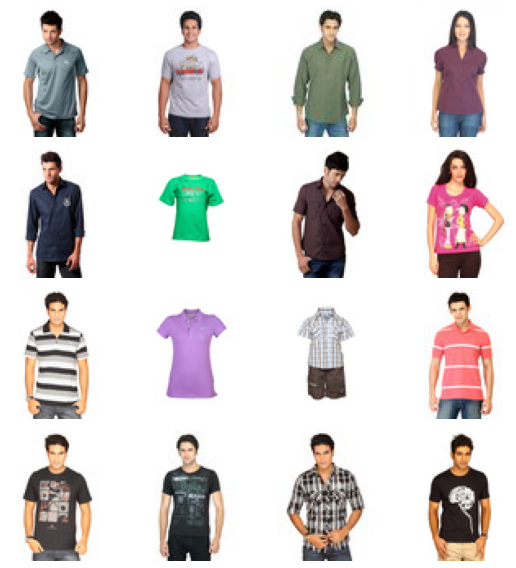

In [158]:
import numpy as np
import random

def plot_album():
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8))
    # this assumes the images are in images_dir/album_name/<name>.jpg
    image_paths = final_images_path
    for imp, ax in zip(image_paths, axes.ravel()):
        img = mpimg.imread(imp)
        ax.imshow(img)
        ax.axis('off')
    fig.tight_layout()
    
plot_album()

## Recommendation

In [175]:
path_select = df_2[df_2['image_path'].isin(final_images_path)]['image_path'].tolist()
path_select_one=path_select[12]
path_select_one

# select one item from matched articles

'5865.jpg'

In [176]:
final_index=int(df_2.index[df_2['image_path'] == path_select_one].tolist()[0])
final_index

# get index of selected item

25

In [2]:
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D

In [110]:
import cv2

import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(7, 7)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"/images/"+img

def load_image(img):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    return img

In [70]:
# Input Shape
img_width, img_height, _ = 32, 32, 3

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [71]:
load_image('9452.jpg').shape

(80, 60, 3)

In [72]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [179]:
emb = get_embedding(model, '13627.jpg')
emb.shape

(24,)

(80, 60, 3)
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2174057e-11
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]


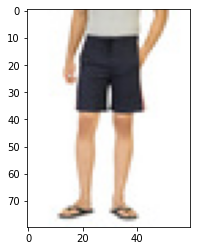

In [180]:
img_array = load_image('13627.jpg')
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [75]:
DATASET_PATH = "C:/Users/maeng/Desktop/archive/myntradataset/"
print(os.listdir(DATASET_PATH))

df_2 = pd.read_csv(DATASET_PATH + 'styles.csv')

df_2['image_path'] = df_2['id'].astype(str) +'.jpg'
df_2=df_2.drop(columns=['gender', 'masterCategory', 'year', 'productDisplayName', 'subCategory'])

array=['Shirts', 'Jeans', 'Tshirts', 'Waistcoat', 'Shorts', 'Blazers', 'Trousers', 'Booties']
df_2 = df_2.loc[df_2['articleType'].isin(array)]

df_2=df_2.dropna(axis=0)
df_2

# data for embedding

['images', 'styles.csv', 'styles2.csv']


,id,articleType,baseColour,season,usage,image_path
0,15970,Shirts,Navy Blue,Fall,Casual,15970.jpg
1,39386,Jeans,Blue,Summer,Casual,39386.jpg
4,53759,Tshirts,Grey,Summer,Casual,53759.jpg
5,1855,Tshirts,Grey,Summer,Casual,1855.jpg
6,30805,Shirts,Green,Summer,Ethnic,30805.jpg
...,...,...,...,...,...,...
44434,1644,Tshirts,Red,Fall,Sports,1644.jpg
44436,30614,Tshirts,Black,Summer,Sports,30614.jpg
44437,13496,Tshirts,Blue,Fall,Casual,13496.jpg
44439,12544,Tshirts,Peach,Fall,Casual,12544.jpg


In [76]:
df_2=df_2.head(1000)
df_2 = df_2.reset_index(drop=True)

In [77]:
df_2.shape

(1000, 6)

In [78]:
%%time
#import swifter

# Parallel apply
df_sample      = df_2#.sample(10)
map_embeddings = df_sample['image_path'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(1000, 2048)
Wall time: 54.1 s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.233825,1.456653,0.000000,0.0,0.0,1.254263,0.0,0.000000,9.369720,0.000000,...,0.000000,0.0,0.0,0.00000,0.000000,0.0,0.618587,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.476282,4.139309,0.000000,...,0.000000,0.0,0.0,0.00000,0.049064,0.0,0.000000,0.000000,0.000000,0.0
2,0.000000,0.935014,0.026755,0.0,0.0,0.000000,0.0,4.029033,5.120055,0.000000,...,0.000000,0.0,0.0,3.38406,0.000000,0.0,0.000000,0.000000,2.004459,0.0
3,0.000000,3.677119,0.000000,0.0,0.0,0.000000,0.0,0.000000,7.283600,0.000000,...,0.283829,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.102561,0.0
4,0.000000,1.804648,0.000000,0.0,0.0,0.000000,0.0,0.000000,8.727765,0.303962,...,1.251515,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.683425,0.602613,0.0


In [79]:
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.9999997, 0.3419066, 0.6054207, 0.638485 ],
       [0.3419066, 1.       , 0.4850933, 0.4183911],
       [0.6054207, 0.4850933, 1.       , 0.7551107],
       [0.638485 , 0.4183911, 0.7551107, 1.       ]], dtype=float32)

In [80]:
indices = pd.Series(range(len(df_2)), index=df_2.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(50, df_2, top_n = 5)

(Int64Index([248, 937, 356, 279, 190], dtype='int64'),
 [0.77050126, 0.77014995, 0.7617008, 0.748005, 0.7398814])

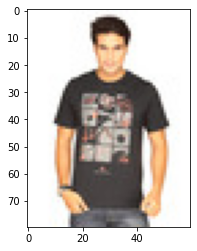

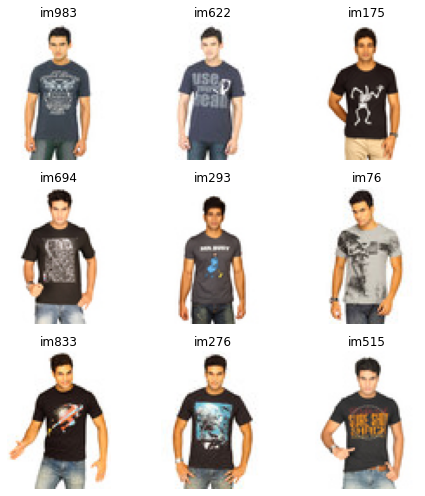

In [178]:
# Idx Item to Recommender
idx_ref = final_index

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df_2, top_n = 9)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df_2.iloc[idx_ref].image_path), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image_path) for i, row in df_2.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 3, 3)